In [1]:
import pandas as pd
import glob as glob
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Bidirectional,Lambda
from tensorflow.keras.layers import LSTM, BatchNormalization, Softmax, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
import math
%matplotlib inline
%load_ext autoreload
%autoreload 2
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## give up

In [ ]:
sample_csv = 'mpc2_sample.csv'
shuffle_csv = 'jst_-4.5.csv'
regnet_csv = 'jst_-3.5.csv'

pf_sample = pd.read_csv(sample_csv)
pf_jst_4 = pd.read_csv(shuffle_csv)
pf_jst_3 = pd.read_csv(regnet_csv)

decision = []

for i in range(len(pf_sample['Decision'])):
    if pf_jst_3['Decision'][i] == pf_jst_4['Decision'][i]:
        pf_sample['Decision'][i] = pf_jst_3['Decision'][i]

pf_sample.to_csv('quit.csv', index=False)

## sample demo

In [2]:
def parse_curve(filepath):
    """
    Parses the curve into a pandas dataframe
    
    WegSpd1 	mm 	Distance traveld by press
    KraftSpd1 	N 	Force spend by press
    K7_1_TL 	% 	Sharpness value top left
    K7_2_TR 	% 	sharpness value top right
    K7_3_BL 	% 	sharpness value bottom left
    K7_4_BR 	% 	sharpness value bottom right
    K7_5_MC 	% 	sharpness value middle center
    """
    df = pd.read_csv(
        filepath, 
        skiprows=33, 
        delimiter=';', 
        dtype=np.float,
        names=['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT'],
        usecols=range(9)
    )
    #df.name = os.path.basename(filepath)
    #num = df.isna().sum()
    #return df, sum(num)
    return df

In [3]:
class CurveSequence(Sequence):
    """
    Helper class to sample and iterating over the dataset
    
    Args:
        df (pandas.DataFrame): Dataframe holding curve paths and labels
        batch_size (int): The batch size 
        n_timesteps (int): Number of steps to be used from the curves
        curve_path (str): Path to directory where curve folders are located
    """

    def __init__(self, df, batch_size=20, n_timesteps=1800, curve_path='/home/deeplearning/data_disk_2/mpc2_data/'):
        self.df = df.copy()
        self.curve_path = curve_path
        self.batch_size = batch_size
        self.n_timesteps = n_timesteps
        
        self.df["ResultFinalCheck"] = self.df['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
        
    def make_batch(self, df_sub):
        dfs = [
            parse_curve(
                os.path.join(self.curve_path, filepath)
            ) for filepath in df_sub['FilePath'].values
        ]

        # Think about how to create batches of equal length without truncating the data.
        # Think about necessary data preparations
        
        X = np.array([
            #df[0:self.n_timesteps][['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT']].values for df in dfs
            df[0:self.n_timesteps][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values for df in dfs
        ])
        
        
        #X = X.std(axis=2)
        
        y = to_categorical(df_sub['ResultFinalCheck'].values, num_classes=2)
        #y = df_sub['ResultFinalCheck'].values
        X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
        X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])
        X = (X - X_mean) / X_std
        
        return X, y

    def __len__(self):
        return math.ceil(self.df.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        df_sub = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.make_batch(df_sub)

In [4]:
from sklearn.utils import class_weight
df_train = pd.read_csv('clean_train_80_pec.csv')
'''
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train['ResultFinalCheck']),
                                                 df_train['ResultFinalCheck'])
'''

"\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                 np.unique(df_train['ResultFinalCheck']),\n                                                 df_train['ResultFinalCheck'])\n"

In [19]:
print(class_weights)

[76.65206261  0.50328291]


In [5]:
not_ok = df_train[df_train.ResultFinalCheck == 'NOK']
ok = df_train[df_train.ResultFinalCheck == 'OK']
print(np.shape(not_ok),np.shape(ok))

(6836, 2) (1041151, 2)


In [6]:
df_train = ok[0:7000]
df_train.append(not_ok)
df_train.head()

,FilePath,ResultFinalCheck
0,MPC2_IM_L3/S42_42/2019_01_18_18h/5c422905_3211...,OK
1,MPC2_IM_L2/S42_P2/2018_11_12_01h/5be8df42_3021...,OK
2,MPC2_IM_L1/S42_P2/2019_01_03_11h/5c2ee145_2131...,OK
3,MPC2_IM_L1/S42_P4/2018_11_09_14h/5be6aa49_2140...,OK
4,MPC2_IM_L3/S42_P3/2018_10_29_11h/5bd714ba_3202...,OK


In [7]:
import sklearn
df_train=sklearn.utils.shuffle(df_train)
df_train.head()

,FilePath,ResultFinalCheck
190,MPC2_IM_L1/S42_P3/2018_12_16_21h/5c179216_2143...,OK
2855,MPC2_IM_L3/S42_P3/2019_02_04_06h/5c58ba48_3284...,OK
2173,MPC2_IM_L1/S42_P4/2018_11_29_11h/5c00ac19_2017...,OK
5995,MPC2_IM_L3/S42_42/2018_10_19_04h/5bc9f6cf_3269...,OK
5619,MPC2_IM_L1/S42_P3/2018_08_28_09h/5b861076_2121...,OK


## failed custome lstm loss

In [9]:
# Define custom loss
def custom_loss():
    def loss(y_true,y_pred):
        TP = 0
        FP = 0
        y_pred = tf.keras.backend.argmax(y_pred)
        for i in range(tf.keras.backend.shape(y_true)):
            if y_true[i] == 0 and y_pred[i] == 0:
                TP = TP + 1
            if y_true[i] == 0 and y_pred[i] == 1:
                FP = FP + 1
        print(-(0.42*TP - FP))
        return -(0.42*TP - FP)
    return loss

def create_lstm():
    """
    How about deeper models?
    """
    model = Sequential()
    model.add(LSTM(25, input_shape=(1800, 5)))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        loss=custom_loss(), 
        optimizer='adam', 
        # Accuracy makes no sense to watch in an imbalanced classification problem.
        # Think about metrics thatcapture model quality way better. How about something motivated by the score below?
        metrics=['accuracy'])
    return model

In [ ]:
def create_model():
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]

    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = layers.Flatten()(end_logits)

    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[start_probs, end_probs],
    )
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss=[loss, loss])
    return model

##  last hope lstm

In [5]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [8]:
def create_lstm():
    """
    How about deeper models?
    """
    model = Sequential()
    model.add(LSTM(25, input_shape=(1800, 5)))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        # Accuracy makes no sense to watch in an imbalanced classification problem.
        # Think about metrics thatcapture model quality way better. How about something motivated by the score below?
        metrics=['accuracy'])
    return model

jst_lstm = create_lstm()
jst_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                3100      
_________________________________________________________________
dense (Dense)                (None, 2)                 52        
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________


In [6]:
def create_jst_lstm():
    """
    How about deeper models?
    """
    
    '''
    model = Sequential()
    model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(1800, 5)))
    model.add(Bidirectional(LSTM(5)))
    #attention
    #model.add(Dense(5))
    #model.add(Softmax())
    #model.add(Lambda(lambda x:x[0]*x[1]))
    
    #model.add(Flatten())
    model.add(Dense(5, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    '''
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
    ]
   
    input_ = keras.Input(shape=(1800, 5))
    _lstm = Bidirectional(LSTM(25, return_sequences=True))(input_)
    _lstm = Bidirectional(LSTM(10))(_lstm)
    attention_pre = Dense(20)(_lstm)
    attention_probs  = Softmax()(attention_pre)
    attention_mul = Lambda(lambda x:x[0]*x[1])([attention_probs, _lstm])
    
    output = Flatten()(attention_mul)
    output = Dense(5, activation = 'relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    output = Dense(2, activation='softmax')(output)
    
    model = keras.Model(inputs = input_ , outputs = output)
    
    model.compile(
        #loss=[binary_focal_loss(alpha=.006, gamma=2)], 
        loss='binary_crossentropy',
        optimizer='rmsprop', 
        # Accuracy makes no sense to watch in an imbalanced classification problem.
        # Think about metrics thatcapture model quality way better. How about something motivated by the score below?
        metrics=METRICS)
    return model

jst_lstm = create_jst_lstm()
jst_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1800, 5)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1800, 50)     6200        input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20)           4880        bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           420         bidirectional_1[0][0]            
______________________________________________________________________________________________

In [7]:
generator_train = CurveSequence(df_train, 256)
class_weight = {0: 76.65206261, 1: 0.50328291}
jst_lstm.fit_generator(generator_train, steps_per_epoch=200, use_multiprocessing=True, epochs=20,class_weight=class_weight)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
200/200 [==============================] - 162s 808ms/step - loss: 0.5138 - tp: 39438.0000 - fp: 11747.0000 - tn: 39453.0000 - fn: 11762.0000 - accuracy: 0.7704 - precision: 0.7705 - recall: 0.7703 - auc: 0.7744
Epoch 2/20
200/200 [==============================] - 167s 835ms/step - loss: 0.4147 - tp: 45091.0000 - fp: 6109.0000 - tn: 45091.0000 - fn: 6109.0000 - accuracy: 0.8807 - precision: 0.8807 - recall: 0.8807 - auc: 0.8904
Epoch 3/20
200/200 [==============================] - 168s 838ms/step - loss: 0.4201 - tp: 45704.0000 - fp: 5496.0000 - tn: 45704.0000 - fn: 5496.0000 - accuracy: 0.8927 - precision: 0.8927 - recall: 0.8927 - auc: 0.9084
Epoch 4/20
200/200 [==============================] - 173s 863ms/step - loss: 0.3478 - tp: 46175.0000 - fp: 5025.0000 - tn: 46175.0000 - fn: 5025.0000 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - auc: 0.9233
Epoch 5/20
200/200 [==================

In [9]:
jst_lstm.save_weights('./model/lstm_pure')

In [5]:
jst_lstm.load_weights('./model/lstm_pure')

In [8]:
df_valid = pd.read_csv('clean_train_20_pec.csv')
generator_eval = CurveSequence(df_valid, batch_size=512)
predictions = jst_lstm.predict_generator(generator_eval, workers=4, use_multiprocessing=True, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
512/512 [==============================] - 426s 832ms/step


In [18]:
valid_y = df_valid['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
threshold = 0.97
abnomal_count = 0
val_result = []
for i in range(np.shape(predictions)[0]):
    if predictions[i][0] > threshold:
        val_result.append(0)
        abnomal_count = abnomal_count + 1
    else:
        #print(predictions[i][0])
        val_result.append(1)

In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels,title):
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(4, 2), dpi=120)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=8, va='center', ha='center')

        else:
            c = cm_normalized[y_val][x_val]
            if (c > 0.01):
                plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=7, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes')
    plt.xlabel('Index of Predict Classes')
    plt.show()

In [20]:
def compute_score(pred, gt):
    n_false_positives = 0
    n_true_positives = 0
    
    n_true_nomal = 0
    n_false_nomal = 0
    for i in range(len(pred)):
        if pred[i] == 1 and gt[i] == 0:
            n_false_positives = n_false_positives + 1
        if pred[i] == 0 and gt[i] == 0:
            n_true_positives = n_true_positives + 1
        if pred[i] == 1 and gt[i] == 1:
            n_true_nomal = n_true_nomal + 1
        if pred[i] == 0 and gt[i] == 1:
            n_false_nomal = n_false_nomal + 1
    print(n_false_positives, n_true_positives)
    print(n_false_nomal, n_true_nomal)
    return 1000*(0.42*n_true_positives - n_false_positives) / len(pred)

In [21]:
print(compute_score(val_result,valid_y))
print(abnomal_count/np.shape(predictions)[0])

604 1011
10451 249930
-0.6846669414800226
0.04374875952304615


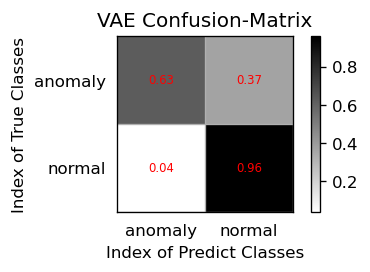

In [22]:
plot_confusion_matrix(valid_y, val_result, ['anomaly','normal'],'VAE Confusion-Matrix')

## commit result

In [23]:
df_test = pd.read_csv('sample_submission.csv')
df_test.shape

(561423, 2)

In [24]:
class CurveSequence(Sequence):
    """
    Helper class to sample and iterating over the dataset
    
    Args:
        df (pandas.DataFrame): Dataframe holding curve paths and labels
        batch_size (int): The batch size 
        n_timesteps (int): Number of steps to be used from the curves
        curve_path (str): Path to directory where curve folders are located
    """

    def __init__(self, df, batch_size=20, n_timesteps=1800, curve_path='/home/deeplearning/data_disk_2/mpc2_data/'):
        self.df = df.copy()
        self.curve_path = curve_path
        self.batch_size = batch_size
        self.n_timesteps = n_timesteps
        
        self.df["Decision"] = self.df['Decision'].replace({'NOK': 0, 'OK': 1})
        
    def make_batch(self, df_sub):
        dfs = [
            parse_curve(
                os.path.join(self.curve_path, filepath)
            ) for filepath in df_sub['FilePath'].values
        ]

        # Think about how to create batches of equal length without truncating the data.
        # Think about necessary data preparations
        X = np.array([
            df[0:self.n_timesteps][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values for df in dfs
        ]) 
        
        X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
        X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])
        X = (X - X_mean) / X_std

        y = to_categorical(df_sub['Decision'].values, num_classes=2)

        return X, y

    def __len__(self):
        return math.ceil(self.df.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        df_sub = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.make_batch(df_sub)

In [25]:
generator_test = CurveSequence(df_test, batch_size=512)
predictions = jst_lstm.predict_generator(generator_test, workers=4, use_multiprocessing=True, verbose=1)

1097/1097 [==============================] - 3905s 4s/step


In [31]:
threshold = 0.9975
test_result = []
count = 0
for i in range(np.shape(predictions)[0]):
    #print(predictions[i])
    if predictions[i][0] > threshold:
        test_result.append('NOK')
        count = count + 1
    else:
        test_result.append('OK')
print(count)

3964


In [32]:
path_name = df_test['FilePath']
cont_list = {'FilePath':path_name, 'Decision':test_result}
df = pd.DataFrame(cont_list, columns=['FilePath','Decision'])
df.to_csv('jst.csv')

In [26]:
print(np.shape(test_result))

(561423,)


## JST LSTM 

In [26]:
def parse_curve(filepath):
    """
    Parses the curve into a pandas dataframe
    
    WegSpd1 	mm 	Distance traveld by press
    KraftSpd1 	N 	Force spend by press
    K7_1_TL 	% 	Sharpness value top left
    K7_2_TR 	% 	sharpness value top right
    K7_3_BL 	% 	sharpness value bottom left
    K7_4_BR 	% 	sharpness value bottom right
    K7_5_MC 	% 	sharpness value middle center
    """
    df = pd.read_csv(
        filepath, 
        skiprows=33, 
        delimiter=';', 
        dtype=np.float,
        names=['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT'],
        usecols=range(9)
    )
    df.name = os.path.basename(filepath)
    num = df.isna().sum()
    #return df, sum(num)
    return df
class CurveSequence(Sequence):
    """
    Helper class to sample and iterating over the dataset
    
    Args:
        df (pandas.DataFrame): Dataframe holding curve paths and labels
        batch_size (int): The batch size 
        n_timesteps (int): Number of steps to be used from the curves
        curve_path (str): Path to directory where curve folders are located
    """

    def __init__(self, df, batch_size=20, n_timesteps=1800, curve_path='/home/deeplearning/data_disk_2/mpc2_data/'):
        self.df = df.copy()
        self.curve_path = curve_path
        self.batch_size = batch_size
        self.n_timesteps = n_timesteps
        
        self.df["ResultFinalCheck"] = self.df['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
        
    def make_batch(self, df_sub):
        dfs = [
            parse_curve(
                os.path.join(self.curve_path, filepath)
            ) for filepath in df_sub['FilePath'].values
        ]

        # Think about how to create batches of equal length without truncating the data.
        # Think about necessary data preparations
        X = np.array([
            df[0:self.n_timesteps][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values for df in dfs
        ]) 
        
        #X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
        #X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])
        #X = (X - X_mean) / X_std
        X = X.std(axis=2)
        #y = to_categorical(df_sub['ResultFinalCheck'].values, num_classes=2)

        return X

    def __len__(self):
        return math.ceil(self.df.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        df_sub = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.make_batch(df_sub)

In [44]:
jst_inputs = keras.Input(shape=(1800, 1))
data_inputs = keras.layers.Lambda(lambda x: x[:,0:900,:])(jst_inputs)
gt_inputs = keras.layers.Lambda(lambda x: x[:,900:1800,:])(jst_inputs)
h = layers.LSTM(40, return_sequences=True)(data_inputs) # intermediate dimension
h = layers.LSTM(20, return_sequences=True)(h)
jst_output = layers.Dense(1, activation=None)(h)

jst_lstm = keras.Model(jst_inputs, jst_output)

# Compute loss
reconstruction_loss = mse(gt_inputs, jst_output)
jst_lstm.add_loss(reconstruction_loss)
jst_lstm.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')

jst_lstm.compile(optimizer='rmsprop')
jst_lstm.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1800, 1)]    0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 900, 1)       0           input_11[0][0]                   
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 900, 40)      6720        lambda_11[0][0]                  
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 900, 20)      4880        lstm_7[0][0]                     
____________________________________________________________________________________________

In [45]:
df_train = pd.read_csv('pure_train_5_pec_70_pec.csv')
#df_test = pd.read_csv('clean_test_5_pec_30_pec.csv')
generator_train = CurveSequence(df_train,batch_size=256)
#generator_eval = CurveSequence(df_test, batch_size=200)

In [46]:
jst_lstm.fit_generator(generator_train, steps_per_epoch=200, epochs=30, workers=4, use_multiprocessing=True)

Epoch 1/30
200/200 [==============================] - 47s 236ms/step - loss: 2.1351 - reconstruction_loss: 2.1351
Epoch 2/30
200/200 [==============================] - 48s 239ms/step - loss: 1.5798 - reconstruction_loss: 1.5798
Epoch 3/30
200/200 [==============================] - 49s 243ms/step - loss: 1.5543 - reconstruction_loss: 1.5543
Epoch 4/30
200/200 [==============================] - 48s 240ms/step - loss: 1.5414 - reconstruction_loss: 1.5414
Epoch 5/30
200/200 [==============================] - 48s 242ms/step - loss: 1.5191 - reconstruction_loss: 1.5191
Epoch 6/30
200/200 [==============================] - 48s 242ms/step - loss: 1.5000 - reconstruction_loss: 1.5000
Epoch 7/30
200/200 [==============================] - 48s 241ms/step - loss: 1.4215 - reconstruction_loss: 1.4215
Epoch 8/30
200/200 [==============================] - 48s 239ms/step - loss: 1.3652 - reconstruction_loss: 1.3652
Epoch 9/30
200/200 [==============================] - 48s 241ms/step - loss: 1.3135 - re

200/200 [==============================] - 47s 234ms/step - loss: 1.0422 - reconstruction_loss: 1.0422


In [47]:
jst_lstm.save_weights('./model/lstm_pure')

In [4]:
jst_lstm = keras.Model(jst_inputs, jst_output)
jst_lstm.load_weights('./model/lstm_pure')

In [30]:
X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])

In [31]:
def plot_curve(df_curve, ax=None):
        
    if not ax:
        _, ax = plt.subplots()
    
    #plt.ylim(0, 50)
    for feature in ['K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC']:
        df_curve[feature].plot(ax=ax, label=feature)
    
    ax.legend(loc='lower right')
    #ax.set_title(df_curve.name)

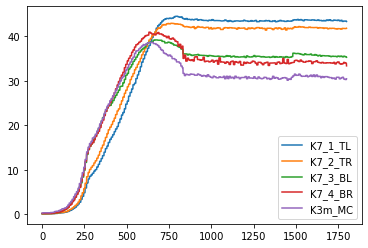

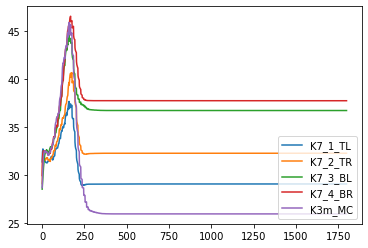

In [32]:
ok_file = 'MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_21442_45660_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, ok_file))
plot_curve(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values]) 
result = jst_lstm.predict(X)
result = np.squeeze(result)

result = result*X_std+X_mean


df_pred = pd.DataFrame(result, columns=["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]) 
plot_curve(df_pred)

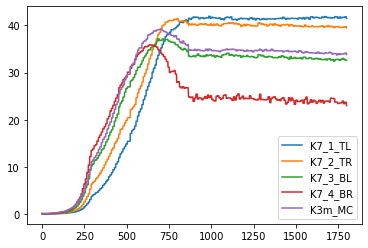

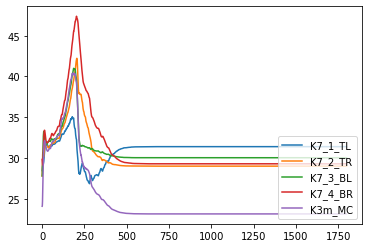

In [24]:
nok_file = 'MPC2_IM_L1/S42_P2/2018_08_25_09h/5b83eb9e_21782_28092_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, nok_file))
plot_curve(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values]) 
result = jst_lstm.predict(X)
result = np.squeeze(result)

result = result*X_std+X_mean


df_pred = pd.DataFrame(result, columns=["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]) 
plot_curve(df_pred)

In [48]:
def feature_std(dfs):
    feature_std = []
    for i in range(len(dfs['K7_1_TL'])):
        feature_std.append(np.std(np.array([dfs['K7_1_TL'][i], dfs['K7_2_TR'][i], dfs['K7_3_BL'][i], dfs['K7_4_BR'][i], dfs['K3m_MC'][i]])))
    
    plt.figure(figsize=(12, 10))
    plt.scatter(range(len(np.array(feature_std))), feature_std)
    plt.show()

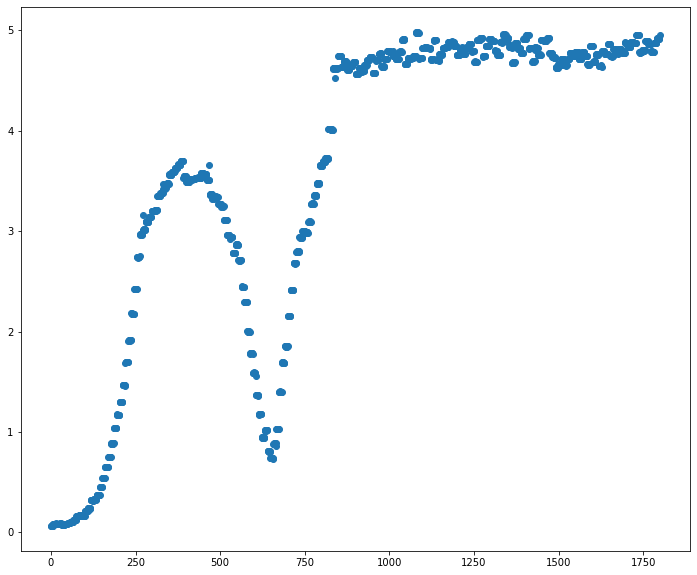

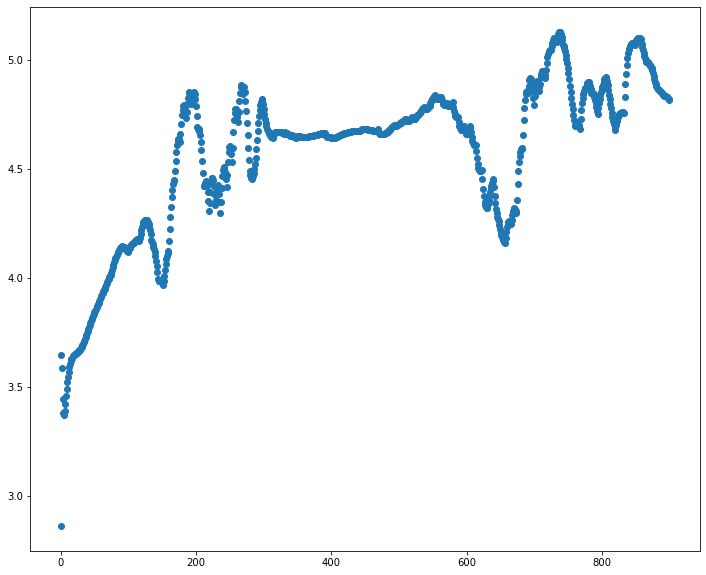

In [49]:
ok_file = 'MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_21442_45660_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, ok_file))
feature_std(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values])
X_test = X.std(axis=2)
result = jst_lstm.predict(X_test)
#result = result[:,:,1]
result = np.squeeze(result)

plt.figure(figsize=(12, 10))
plt.scatter(range(len(np.array(result))), result)
plt.show()

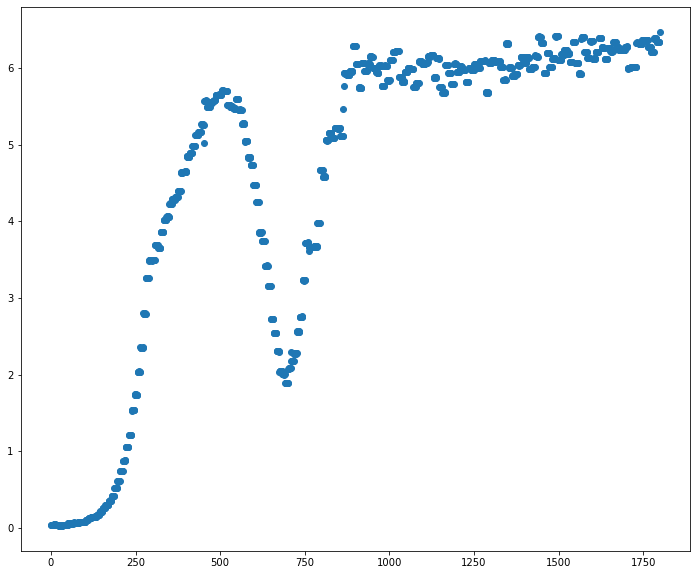

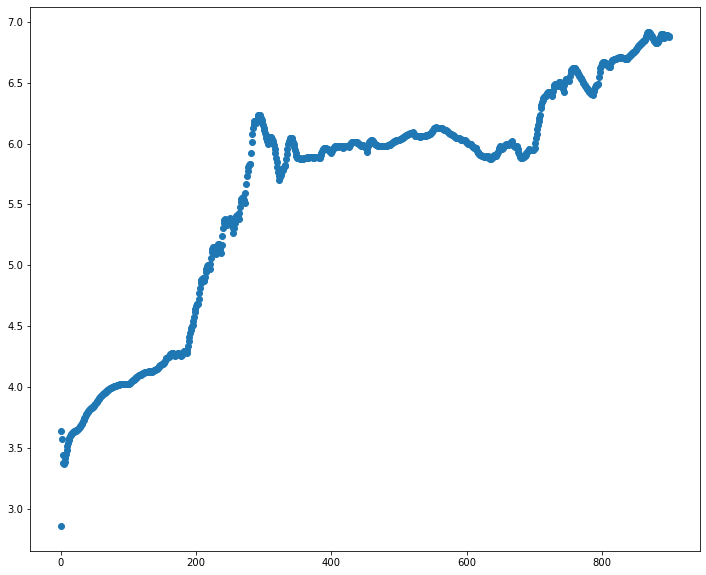

In [50]:
nok_file = 'MPC2_IM_L1/S42_P2/2018_08_25_09h/5b83eb9e_21782_28092_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, nok_file))
feature_std(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values])
X = X.std(axis=2)
result = jst_lstm.predict(X)
result = np.squeeze(result)

plt.figure(figsize=(12, 10))
plt.scatter(range(len(np.array(result))), result)
plt.show()

## find threshold

In [ ]:
model = keras.Model(jst_inputs, jst_output)
model.load_weights('./model/lstm_pure')

In [51]:
df_train = pd.read_csv('find_threshold.csv')
generator_eval = CurveSequence(df_train, batch_size=1)
recon_error = keras.Model(jst_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
result = recon_error.predict_generator(generator_eval, workers=8, use_multiprocessing=True, verbose=1)

1310/1310 [==============================] - 34s 26ms/step


In [52]:
not_ok = df_train[df_train.ResultFinalCheck == 'NOK']
ok = df_train[df_train.ResultFinalCheck == 'OK']
print(not_ok.shape[0]/(ok.shape[0]+not_ok.shape[0]))
threshold=not_ok.shape[0]/(ok.shape[0]+not_ok.shape[0])

0.006870229007633588


7.076594491041344


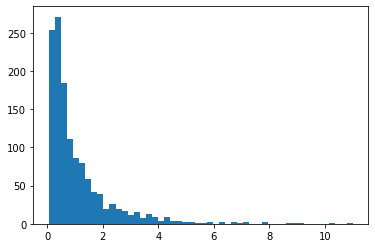

In [53]:
from matplotlib import pyplot as plt

judge_loss = np.percentile(result,(1-threshold)*100)
print(judge_loss)

plt.hist(result, 50) # bins = 50，顺便可以控制bin宽度
plt.show()

## eval on valid set

In [54]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels,title):
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(4, 2), dpi=120)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=8, va='center', ha='center')

        else:
            c = cm_normalized[y_val][x_val]
            if (c > 0.01):
                plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=7, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes')
    plt.xlabel('Index of Predict Classes')
    plt.show()

In [ ]:
dist = np.linalg.norm(testing_dataset - result_df, axis=-1)
judge_loss = np.percentile(prediction_thresh,(1-threshold)*100)

In [55]:
#valid set test
df_valid = pd.read_csv('clean_test_5_pec_30_pec.csv')
valid_y = df_valid['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
generator_valid = CurveSequence(df_valid, batch_size=1)

recon_error = keras.Model(jst_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
predict_valid = recon_error.predict_generator(generator_valid, workers=8, use_multiprocessing=True, verbose=1)

13071/13071 [==============================] - 365s 28ms/step


In [56]:
val_result = []
for i in range(len(predict_valid)):
    if predict_valid[i] > judge_loss:
        val_result.append(0)
    else:
        val_result.append(1)

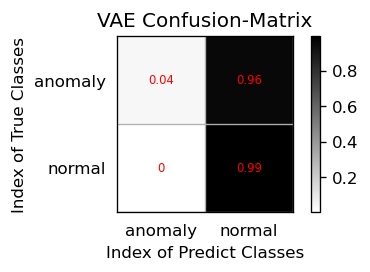

In [57]:
plot_confusion_matrix(valid_y, val_result, ['anomaly','normal'],'VAE Confusion-Matrix')

In [58]:
judge_loss = np.percentile(predict_valid,(1-threshold)*100)
print(judge_loss)

6.704702067921186


In [59]:
def compute_score(pred, gt):
    n_false_positives = 0
    n_true_positives = 0
    for i in range(len(pred)):
        if pred[i] == 1 and gt[i] == 0:
            n_false_positives = n_false_positives + 1
        if pred[i] == 0 and gt[i] == 0:
            n_true_positives = n_true_positives + 1
    print(n_false_positives, n_true_positives)
    return 1000*(0.42*n_true_positives - n_false_positives) / len(pred)

In [60]:
print(compute_score(val_result,valid_y))

101 4
-7.598500497284064


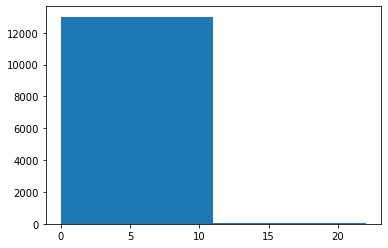

In [43]:
from matplotlib import pyplot as plt

plt.hist(predict_valid, 2) # bins = 50，顺便可以控制bin宽度
plt.show()

In [39]:
min(predict_valid), max(predict_valid)

(0.008644622, 0.5467565)

In [53]:
valid_y = df_test['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})

## VAE-LSTM

In [3]:
def parse_curve(filepath):
    """
    Parses the curve into a pandas dataframe
    
    WegSpd1 	mm 	Distance traveld by press
    KraftSpd1 	N 	Force spend by press
    K7_1_TL 	% 	Sharpness value top left
    K7_2_TR 	% 	sharpness value top right
    K7_3_BL 	% 	sharpness value bottom left
    K7_4_BR 	% 	sharpness value bottom right
    K7_5_MC 	% 	sharpness value middle center
    """
    df = pd.read_csv(
        filepath, 
        skiprows=33, 
        delimiter=';', 
        dtype=np.float,
        names=['WegSpd1','KraftSpd1','K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC','K_7m)','MT'],
        usecols=range(9)
    )
    df.name = os.path.basename(filepath)
    num = df.isna().sum()
    #return df, sum(num)
    return df
class CurveSequence(Sequence):
    """
    Helper class to sample and iterating over the dataset
    
    Args:
        df (pandas.DataFrame): Dataframe holding curve paths and labels
        batch_size (int): The batch size 
        n_timesteps (int): Number of steps to be used from the curves
        curve_path (str): Path to directory where curve folders are located
    """

    def __init__(self, df, batch_size=20, n_timesteps=1800, curve_path='/home/deeplearning/data_disk_2/mpc2_data/'):
        self.df = df.copy()
        self.curve_path = curve_path
        self.batch_size = batch_size
        self.n_timesteps = n_timesteps
        
        self.df["ResultFinalCheck"] = self.df['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
        
    def make_batch(self, df_sub):
        dfs = [
            parse_curve(
                os.path.join(self.curve_path, filepath)
            ) for filepath in df_sub['FilePath'].values
        ]

        # Think about how to create batches of equal length without truncating the data.
        # Think about necessary data preparations
        X = np.array([
            df[0:self.n_timesteps][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values for df in dfs
        ]) 
        
        X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
        X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])
        X = (X - X_mean) / X_std
        #X = X.std(axis=2)
        #y = to_categorical(df_sub['ResultFinalCheck'].values, num_classes=2)

        return X

    def __len__(self):
        return math.ceil(self.df.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        df_sub = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.make_batch(df_sub)

In [4]:
def plot_curve(df_curve, ax=None):
        
    if not ax:
        _, ax = plt.subplots()
    
    #plt.ylim(0, 50)
    for feature in ['K7_1_TL','K7_2_TR','K7_3_BL','K7_4_BR','K3m_MC']:
        df_curve[feature].plot(ax=ax, label=feature)
    
    ax.legend(loc='lower right')
    #ax.set_title(df_curve.name)

In [5]:
latent_dim=20
Intermediate_dim=40

#encoder LSTM
jst_inputs = keras.Input(shape=(1800, 5))
data_inputs = keras.layers.Lambda(lambda x: x[:,0:900,:])(jst_inputs)
gt_inputs = keras.layers.Lambda(lambda x: x[:,900:1800,:])(jst_inputs)
encoded = layers.LSTM(Intermediate_dim, name='EncoderLSTM')(data_inputs) # intermediate dimension
z_mean = layers.Dense(latent_dim)(encoded)
z_log_var = layers.Dense(latent_dim)(encoded)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#decoder LSTM
decoded = layers.RepeatVector(900, name='EmbeddingtoTimeSeries')(z) #timesteps
decoded = layers.LSTM(Intermediate_dim,name='DecoderLSTM1', return_sequences=True)(decoded) #intermediate dimensions
#decoded = layers.LSTM(5,name='DecoderLSTM2', return_sequences=True, activation=None)(decoded) #input_dim
decoded = layers.Dense(5, activation=None)(decoded)

lstm_vae = keras.Model(jst_inputs, decoded)

# Compute VAE loss
reconstruction_loss = mse(gt_inputs, decoded)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
lstm_vae.add_loss(vae_loss)
lstm_vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
lstm_vae.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')

lstm_vae.compile(optimizer='rmsprop')
lstm_vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1800, 5)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 900, 5)       0           input_1[0][0]                    
__________________________________________________________________________________________________
EncoderLSTM (LSTM)              (None, 40)           7360        lambda[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           820         EncoderLSTM[0][0]                
______________________________________________________________________________________________

In [6]:
#Train the VAE
df_train = pd.read_csv('pure_train_5_pec_70_pec.csv')
generator_train = CurveSequence(df_train, batch_size=256)

#vae.fit_generator(generator_train, steps_per_epoch=200, epochs=50, workers=4, use_multiprocessing=True)
#vae.fit(generator_train, steps_per_epoch=200, epochs=10, workers=4, use_multiprocessing=True)
lstm_vae.fit(generator_train, steps_per_epoch=200, epochs=10, workers=4, use_multiprocessing=True)


Epoch 1/10
200/200 [==============================] - 45s 224ms/step - loss: 3.4848 - kl_loss: 3.3297 - reconstruction_loss: 0.1552
Epoch 2/10
200/200 [==============================] - 46s 232ms/step - loss: 0.2808 - kl_loss: 0.1526 - reconstruction_loss: 0.1281
Epoch 3/10
200/200 [==============================] - 47s 236ms/step - loss: 0.2145 - kl_loss: 0.0871 - reconstruction_loss: 0.1273
Epoch 4/10
200/200 [==============================] - 47s 234ms/step - loss: 0.1854 - kl_loss: 0.0583 - reconstruction_loss: 0.1270
Epoch 5/10
200/200 [==============================] - 46s 231ms/step - loss: 0.1686 - kl_loss: 0.0419 - reconstruction_loss: 0.1266
Epoch 6/10
200/200 [==============================] - 46s 231ms/step - loss: 0.1573 - kl_loss: 0.0306 - reconstruction_loss: 0.1266
Epoch 7/10
200/200 [==============================] - 46s 229ms/step - loss: 0.1502 - kl_loss: 0.0236 - reconstruction_loss: 0.1265
Epoch 8/10
200/200 [==============================] - 46s 231ms/step - loss:

In [7]:
lstm_vae.save_weights('./model/lstm_vae')

In [11]:
def feature_std(dfs):
    feature_std = []
    for i in range(len(dfs['WegSpd1'])):
        feature_std.append(np.std(np.array([dfs['K7_1_TL'][i], dfs['K7_2_TR'][i], dfs['K7_3_BL'][i], dfs['K7_4_BR'][i], dfs['K3m_MC'][i]])))
    
    plt.figure(figsize=(12, 10))
    plt.scatter(range(len(np.array(feature_std))), feature_std)
    plt.show()

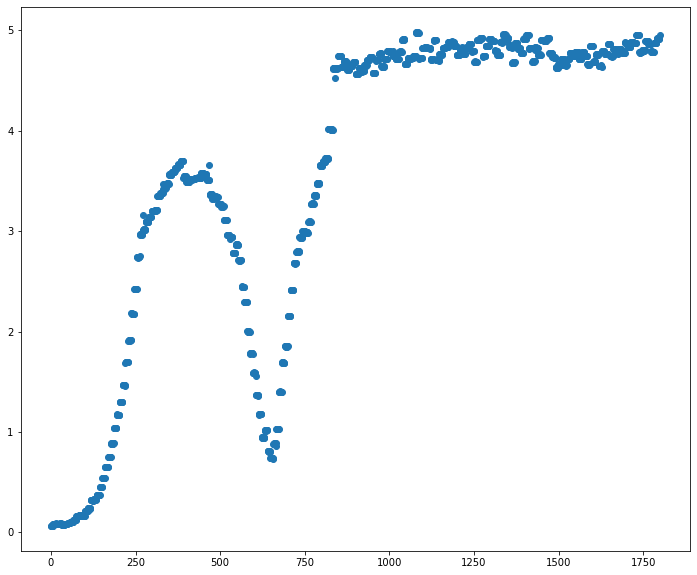

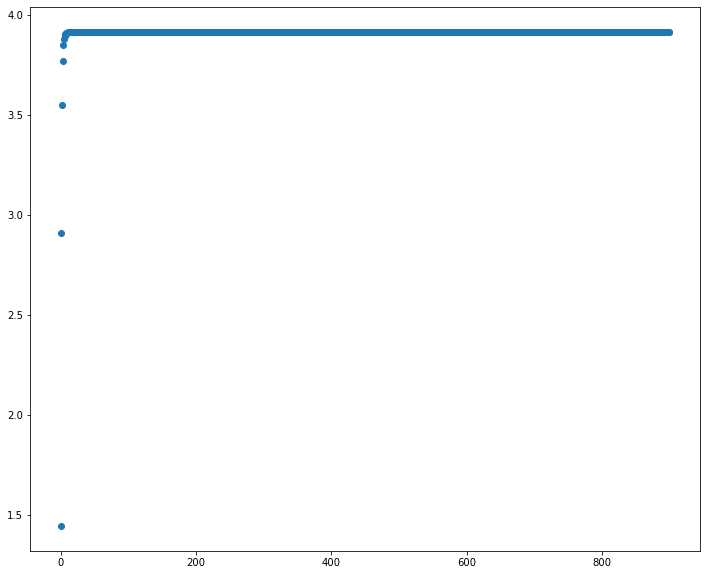

In [12]:
ok_file = 'MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_21442_45660_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, ok_file))
feature_std(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values])
X = X.std(axis=2)
#scaler = MinMaxScaler(feature_range = (0, 1))
#X = scaler.fit_transform(X)
result = lstm_vae.predict(X)
result = np.squeeze(result)

plt.figure(figsize=(12, 10))
plt.scatter(range(len(np.array(result))), result)
plt.show()

In [8]:
X_mean = np.array([30.917057, 30.875045, 30.826165, 30.879995, 28.995421])
X_std = np.array([1.259245e+01, 1.269009e+01, 1.217232e+01, 1.233527e+01, 1.052125e+01])

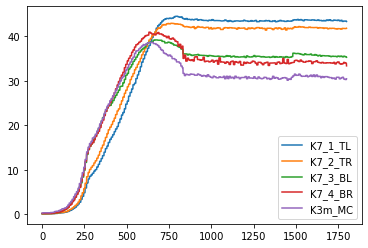

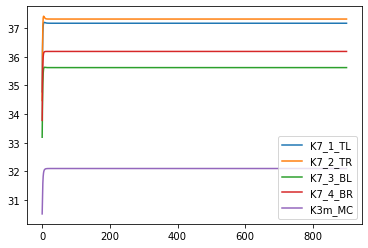

In [9]:
ok_file = 'MPC2_IM_L1/S42_P3/2018_09_07_06h/5b92a587_21442_45660_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, ok_file))
plot_curve(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values]) 
result = lstm_vae.predict(X)
result = np.squeeze(result)

result = result*X_std+X_mean


df_pred = pd.DataFrame(result, columns=["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]) 
plot_curve(df_pred)

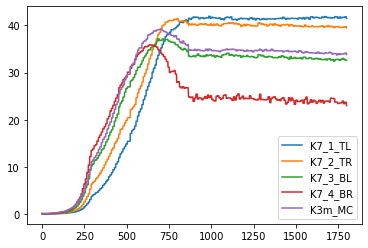

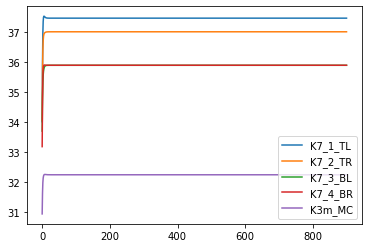

In [10]:
nok_file = 'MPC2_IM_L1/S42_P2/2018_08_25_09h/5b83eb9e_21782_28092_IO.1'
curve_path = '/home/deeplearning/data_disk_2/mpc2_data/'
df = parse_curve(os.path.join(curve_path, nok_file))
plot_curve(df[0:1800])

X = np.array([df[0:1800][["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]].values]) 
result = lstm_vae.predict(X)
result = np.squeeze(result)

result = result*X_std+X_mean


df_pred = pd.DataFrame(result, columns=["K7_1_TL", "K7_2_TR", "K7_3_BL", "K7_4_BR", "K3m_MC"]) 
plot_curve(df_pred)

## find threshold

In [11]:
#find NOK ratio
df_train = pd.read_csv('clean_train_5_pec_70_pec.csv')
generator_train = CurveSequence(df_train, batch_size=1)

recon_error = keras.Model(jst_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
result = recon_error.predict_generator(generator_train, workers=8, use_multiprocessing=True, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
42233/52283 [=======================>......] - ETA: 4:27

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



52283/52283 [==============================] - 1394s 27ms/step


In [8]:
not_ok = df_train[df_train.ResultFinalCheck == 'NOK']
ok = df_train[df_train.ResultFinalCheck == 'OK']
print(not_ok.shape[0]/(ok.shape[0]+not_ok.shape[0]))
threshold=not_ok.shape[0]/(ok.shape[0]+not_ok.shape[0])

0.005929269552244516


In [9]:
judge_loss = np.percentile(result,(1-threshold)*100)
print(judge_loss)

0.4566790878646202


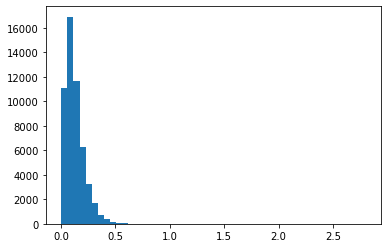

In [10]:
from matplotlib import pyplot as plt

plt.hist(result, 50) # bins = 50，顺便可以控制bin宽度
plt.show()

In [11]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels,title):
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(4, 2), dpi=120)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=8, va='center', ha='center')

        else:
            c = cm_normalized[y_val][x_val]
            if (c > 0.01):
                plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=7, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes')
    plt.xlabel('Index of Predict Classes')
    plt.show()

In [13]:
#valid set test
df_valid = pd.read_csv('clean_test_5_pec_30_pec.csv')
valid_y = df_valid['ResultFinalCheck'].replace({'NOK': 0, 'OK': 1})
generator_valid = CurveSequence(df_valid, batch_size=1)

recon_error = keras.Model(jst_inputs, [tf.reduce_mean(reconstruction_loss)], name="recon_error")
predict_valid = recon_error.predict_generator(generator_valid, workers=8, use_multiprocessing=True, verbose=1)

13071/13071 [==============================] - 380s 29ms/step


In [14]:
val_result = []
for i in range(len(predict_valid)):
    if predict_valid[i] > judge_loss:
        val_result.append(0)
    else:
        val_result.append(1)

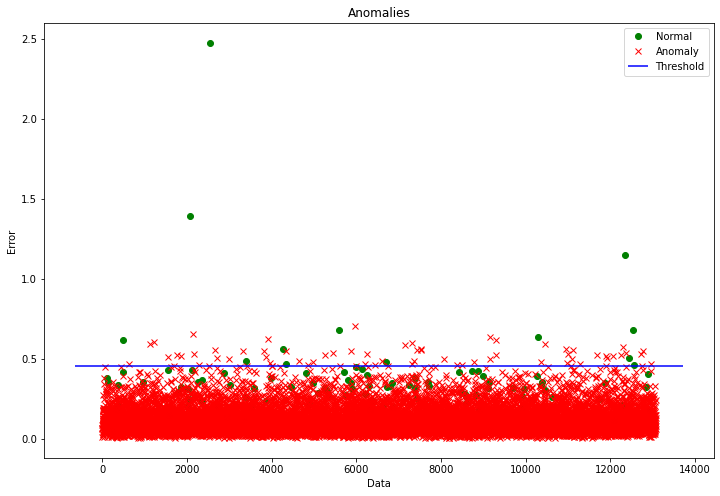

In [15]:
viz = Visualization()
viz.draw_anomaly(valid_y, predict_valid, judge_loss)

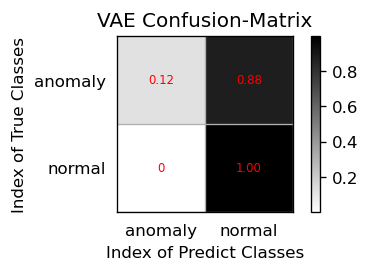

In [16]:
plot_confusion_matrix(valid_y, val_result, ['anomaly','normal'],'VAE Confusion-Matrix')

In [17]:
def compute_score(pred, gt):
    n_false_positives = 0
    n_true_positives = 0
    for i in range(len(pred)):
        if pred[i] == 1 and gt[i] == 0:
            n_false_positives = n_false_positives + 1
        if pred[i] == 0 and gt[i] == 0:
            n_true_positives = n_true_positives + 1
    print(n_false_positives, n_true_positives)
    return 1000*(0.42*n_true_positives - n_false_positives) / len(pred)

In [18]:
print(compute_score(val_result, valid_y))

92 13
-6.620763522301278
